In [1]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
sys.path.append('../input/pytorch-optimizers/')

In [2]:
import os
import gc
import cv2
import copy
import time
import yaml
import random
import shutil
import warnings
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob as glob_file
from tqdm import tqdm
from PIL import Image, ImageDraw
from shutil import copyfile
from IPython.core.display import Video, display
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, GroupKFold, StratifiedKFold

import timm
import torch
from fastai.vision.all import *

warnings.simplefilter('ignore')
pd.set_option("max_columns", 150)
pd.set_option('display.max_rows', 150)

# Configuration

In [3]:
CFG = {
    "save_prev"     : [True, ["petfinder_*4*"]],
    "seed"          : 42,
    'device'        : "cuda:0" if torch.cuda.is_available() else "cpu",
    "input_trimg"   : '../input/petfinder-pawpularity-score/train/',
    "input_trpath"  : '../input/petfinder-smogn-dataset/train_drop_duplicated.csv',
    "input_eximg"   : '../input/petfinder-adoption-prediction/train_images/',
    "input_expath"  : '../input/petfinder-pseudolabel-dataset/train.csv',
    "output_path"   : './',
    "save_name"     : "petfinder_swin_rmse_ss_fastai",
    "model"         : "swin_large_patch4_window7_224_in22k",
    "loss"          : "rmse",
    "size"          : 224,
    "fold"          : 4,
    "batch_size"    : 32,
    "epochs"        : 5,
    "n_data"        : 30000,
    "mixup_ratio"   : 0,
    "lr"            : 1e-4,
    'early_stopping': 3,
    "num_workers"   : 4
}

CFG

{'save_prev': [True, ['petfinder_*4*']],
 'seed': 42,
 'device': 'cuda:0',
 'input_trimg': '../input/petfinder-pawpularity-score/train/',
 'input_trpath': '../input/petfinder-smogn-dataset/train_drop_duplicated.csv',
 'input_eximg': '../input/petfinder-adoption-prediction/train_images/',
 'input_expath': '../input/petfinder-pseudolabel-dataset/train.csv',
 'output_path': './',
 'save_name': 'petfinder_swin_rmse_ss_fastai',
 'model': 'swin_large_patch4_window7_224_in22k',
 'loss': 'rmse',
 'size': 224,
 'fold': 4,
 'batch_size': 32,
 'epochs': 5,
 'n_data': 30000,
 'mixup_ratio': 0,
 'lr': 0.0001,
 'early_stopping': 3,
 'num_workers': 4}

In [4]:
def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    return im_rgb

def sigmoid(a):
    return 1 / (1 + np.exp(-a))

def softmax(x):
    max = np.max(x,axis=1,keepdims=True)
    e_x = np.exp(x - max)
    sum = np.sum(e_x,axis=1,keepdims=True)
    return e_x / sum 

def seed_everything(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG["seed"])

In [5]:
if CFG['save_prev'][0]:
    for file_pattern in CFG['save_prev'][1]:
        for f in glob_file(f"../input/petfinder-fastai-semisupervised-models/{file_pattern}"):
            filename = os.path.basename(f)
            print(filename)
            !cp {f} ./{filename.replace("efnet","effnet")}

petfinder_swin_binary_ss_fastai_smogn_4.pth
petfinder_beit_binary_ss_fastai_4.pth
petfinder_swin_binary_ss_fastai_4.pth
petfinder_effnet_binary_ss_fastai_4.pth


# Load data

In [6]:
df_train = pd.read_csv(CFG['input_trpath'])
df_train["path"] = [f"{CFG['input_trimg']}{i}.jpg" for i in df_train.Id]
df_train["Pawclass"] = df_train.Pawpularity / 100

df_exdata = pd.read_csv(CFG['input_expath'])
df_exdata["Pawclass"] = df_exdata.Pawpularity / 100

print(df_train.shape, df_exdata.shape)
display(df_train.head(2))
display(df_exdata.head(2))

(9860, 16) (58311, 3)


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path,Pawclass
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,../input/petfinder-pawpularity-score/train/0007de18844b0dbbb5e1f607da0606e0.jpg,0.63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,../input/petfinder-pawpularity-score/train/0009c66b9439883ba2750fb825e1d7db.jpg,0.42


,path,Pawpularity,Pawclass
0,../input/petfinder-adoption-prediction/train_images/cf8d949f9-2.jpg,33.240160,0.332402
1,../input/petfinder-adoption-prediction/train_images/61d4dc56b-12.jpg,23.821459,0.238215


<AxesSubplot:>

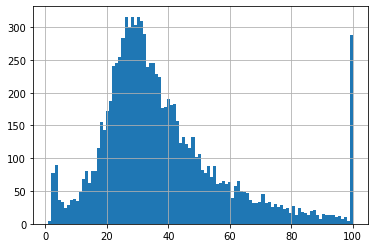

In [7]:
df_train.Pawpularity.hist(bins=100)

<AxesSubplot:>

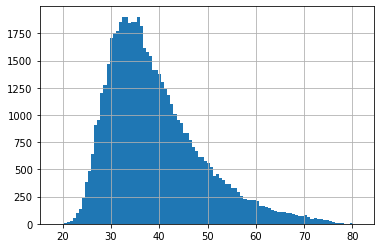

In [8]:
df_exdata.Pawpularity.hist(bins=100)

# Define model

In [9]:
def prepare_dataloader(df):
    df = df.copy()
    label_col  = "Pawclass" if CFG["loss"] == "binary" else "Pawpularity"
    dataloader = ImageDataLoaders.from_df(
        df,
        valid_pct=0,
        seed=CFG["seed"],
        fn_col='path',
        label_col=label_col,
        y_block=RegressionBlock,
        bs=CFG['batch_size'],
        n=CFG["n_data"],
        shuffle=True,
        num_workers=CFG['num_workers'],
        item_tfms=Resize(CFG['size']),
        batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation(), Flip()])
    )
    return dataloader

# def petfinder_rmse(input, target):
#     return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))

def petfinder_rmse(input, target):
    return torch.sqrt(F.mse_loss(input.flatten(), target))

class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = F.mse_loss
        
    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat.flatten(), y))

In [10]:
class Model(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, in_chans=3)
        self.n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(self.n_features, 1)

    def forward(self, x):
        output = self.model(x)
        return output

class TransformerModel(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super().__init__()
        self.model   = timm.create_model(model_name, pretrained=pretrained, num_classes=0, in_chans=3)
        num_features = self.model.num_features
        self.linear  = nn.Linear(num_features, 1)

    def forward(self, x):
        x = self.model(x)
        output = self.linear(x)
        return output

def get_learner(df):
    dataloader = prepare_dataloader(df)
    if -1 < max(CFG["model"].find("swin"), CFG["model"].find("beit")):
        model = TransformerModel(CFG["model"], pretrained=True)
    else:
        model = Model(CFG["model"], pretrained=True)
    learner = Learner(
        dataloader,
        model,
        loss_func=RMSELoss(),
        metrics=AccumMetric(petfinder_rmse)).to_fp16()
    return learner

# Run training

In [11]:
learn = get_learner(df_exdata)
learn.fit_one_cycle(
    CFG["epochs"],
    CFG["lr"],
    cbs=[SaveModelCallback(every_epoch=True, fname=CFG['save_name'])]
)

!mv ./models/* {CFG['output_path']}
!rm -rf ./models

del learn
torch.cuda.empty_cache()
gc.collect()

Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_large_patch4_window7_224_22k.pth" to /root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22k.pth


epoch,train_loss,valid_loss,petfinder_rmse,time
0,9.567605,None,None,22:25
1,9.898477,None,None,22:23
2,9.238946,None,None,22:21
3,6.019960,None,None,22:21
4,4.538629,None,None,22:22


10624